In [1]:
import psycopg
from configparser import ConfigParser
from pathlib import Path

import numpy as np
import pandas as pd

SELECT
	timestamp::date AS date,
	(array_agg(mid_price ORDER BY timestamp ASC))[1] AS mid_open,
	(array_agg(mid_price ORDER BY timestamp DESC))[1] AS mid_close,
	MAX(mid_price) as mid_high,
	MIN(mid_price) as mid_low,
	AVG(mid_price) as mid_average,
	AVG(mark_price) as mark_average,
	AVG(mid_price - mark_price) as mid_mark_avgdiff,
	AVG(volume) as volume,
	AVG(open_interest) as open_interest,
	instrument_name
FROM market.deribit

WHERE instrument_name in ('BTC-PERPETUAL', 'BTC-26MAR21') 
-- AND sectype = 'FUT'
-- AND base_currency = 'BTC'
AND timestamp::date <= '2021-03-26'
/*Option specific:*/
--AND pcflag = 'P'
--AND strike = 8000

GROUP BY
	date,
	instrument_name
	
ORDER BY date DESC


In [2]:
section = 'wmdnatp'
config_parser = ConfigParser()
config_parser.read('natp.ini')
config_parser.has_section(section)
config_params = config_parser.items(section)

db_conn_list = list()

for config_param in config_params:
    k = config_param[0]
    v = config_param[1]
    db_conn_list.append(k+'='+v)

In [3]:
section = 'wmdnatp'
config_parser = ConfigParser()
config_parser.read('natp.ini')
config_parser.has_section(section)
config_params = config_parser.items(section)

db_conn_str = ''

for config_param in config_params:
    k = config_param[0]
    v = config_param[1]
    db_conn_str +=(k+'='+v+' ')

In [114]:
db_conn_str = '''user = natp password = DJCqM07Ynk1yjBxPG9Phc0D2oYprfPDA dbname = AxWMD instance = postgresinstance host = postgresinstance.cjef4gf6dlkg.eu-central-1.rds.amazonaws.com port = 5432
'''

db_conn_str

'user = natp password = DJCqM07Ynk1yjBxPG9Phc0D2oYprfPDA dbname = AxWMD instance = postgresinstance host = postgresinstance.cjef4gf6dlkg.eu-central-1.rds.amazonaws.com port = 5432\n'

username = natp
password = DJCqM07Ynk1yjBxPG9Phc0D2oYprfPDA
dbname = AxWMD
instance = postgresinstance
host = postgresinstance.cjef4gf6dlkg.eu-central-1.rds.amazonaws.com
port = 5432

In [140]:
engine = psycopg.connect('user=natp password=DJCqM07Ynk1yjBxPG9Phc0D2oYprfPDA dbname=AxWMD host=postgresinstance.cjef4gf6dlkg.eu-central-1.rds.amazonaws.com')

In [141]:
cur = engine.cursor()

In [144]:
sql = '''
SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS 
WHERE TABLE_NAME = 'deribit'
'''

cur.execute(sql)
columns = cur.fetchall()
columns = [c[0] for c in columns]

In [145]:
columns

['timestamp',
 'instrument_name',
 'sectype',
 'base_currency',
 'quote_currency',
 'expiry',
 'strike',
 'pcflag',
 'mid_price',
 'mark_price',
 'low',
 'high',
 'bid_price',
 'ask_price',
 'last',
 'estimated_delivery_price',
 'volume_usd',
 'volume',
 'price_change',
 'open_interest',
 'funding_8h',
 'current_funding',
 'underlying_index',
 'underlying_price',
 'interest_rate',
 'creation_timestamp',
 'volume_notional']

In [146]:
sql = '''
SELECT * FROM market.deribit
WHERE sectype = 'FUT'
'''
cur.execute(sql)
data = cur.fetchall()

In [147]:
data_df = pd.DataFrame(data)
data_df.columns = columns

In [148]:
data_df.head(5)

,timestamp,instrument_name,sectype,base_currency,quote_currency,expiry,strike,pcflag,mid_price,mark_price,...,volume,price_change,open_interest,funding_8h,current_funding,underlying_index,underlying_price,interest_rate,creation_timestamp,volume_notional
0,2022-08-17 09:38:58.662000+00:00,ETH-30JUN23,FUT,ETH,USD,2023-06-30,None,None,1890.25,1889.31,...,615.42,-0.6196,15738727.0,NaN,NaN,None,None,None,1660729138662,1171259.0
1,2022-08-17 09:38:58.662000+00:00,ETH-30SEP22,FUT,ETH,USD,2022-09-30,None,None,1872.73,1872.57,...,12409.32,-0.0908,104613400.0,NaN,NaN,None,None,None,1660729138662,23401646.0
2,2022-08-17 09:38:58.662000+00:00,ETH-31MAR23,FUT,ETH,USD,2023-03-31,None,None,1883.50,1883.22,...,2379.70,-0.0833,52306595.0,NaN,NaN,None,None,None,1660729138662,4531261.0
3,2022-08-17 09:38:58.662000+00:00,ETH-30DEC22,FUT,ETH,USD,2022-12-30,None,None,1869.78,1869.81,...,5408.13,0.1151,89517876.0,NaN,NaN,None,None,None,1660729138662,10187275.0
4,2022-08-17 09:38:58.662000+00:00,ETH-19AUG22,FUT,ETH,USD,2022-08-19,None,None,1892.20,1891.79,...,4087.80,-0.0714,4523973.0,NaN,NaN,None,None,None,1660729138662,7825616.0


In [151]:
data_df.to_csv('deribit_futures.csv')

In [154]:
_id = data_df.instrument_name == 'ETH-PERPETUAL'
data_df.loc[_id].head()

,timestamp,instrument_name,sectype,base_currency,quote_currency,expiry,strike,pcflag,mid_price,mark_price,...,volume,price_change,open_interest,funding_8h,current_funding,underlying_index,underlying_price,interest_rate,creation_timestamp,volume_notional
13,2022-08-17 09:33:57.998000+00:00,ETH-PERPETUAL,FUT,ETH,USD,None,None,None,1894.18,1894.13,...,122353.61,0.1825,322747166.0,-0.000002,0.0,None,None,None,1660728837998,232702655.0
27,2022-08-17 09:28:57.118000+00:00,ETH-PERPETUAL,FUT,ETH,USD,None,None,None,1889.82,1889.81,...,122238.51,-0.0925,322705576.0,-0.000002,0.0,None,None,None,1660728537118,232484443.0
41,2022-08-17 09:23:56.563000+00:00,ETH-PERPETUAL,FUT,ETH,USD,None,None,None,1888.13,1888.04,...,122101.55,-0.2668,322638347.0,-0.000003,0.0,None,None,None,1660728236563,232227347.0
55,2022-08-17 09:18:56.188000+00:00,ETH-PERPETUAL,FUT,ETH,USD,None,None,None,1884.18,1884.17,...,122462.37,-0.2251,322607603.0,-0.000003,0.0,None,None,None,1660727936188,232910658.0
69,2022-08-17 09:13:54.714000+00:00,ETH-PERPETUAL,FUT,ETH,USD,None,None,None,1885.78,1886.03,...,122497.40,-0.3172,322584836.0,-0.000003,0.0,None,None,None,1660727634714,232977170.0


In [158]:
pd.set_option('display.max_columns', None)
data_df.loc[_id, :].head()

,timestamp,instrument_name,sectype,base_currency,quote_currency,expiry,strike,pcflag,mid_price,mark_price,low,high,bid_price,ask_price,last,estimated_delivery_price,volume_usd,volume,price_change,open_interest,funding_8h,current_funding,underlying_index,underlying_price,interest_rate,creation_timestamp,volume_notional
13,2022-08-17 09:33:57.998000+00:00,ETH-PERPETUAL,FUT,ETH,USD,None,None,None,1894.18,1894.13,1851.0,1956.95,1894.15,1894.20,1894.10,1894.60,232702655.0,122353.61,0.1825,322747166.0,-0.000002,0.0,None,None,None,1660728837998,232702655.0
27,2022-08-17 09:28:57.118000+00:00,ETH-PERPETUAL,FUT,ETH,USD,None,None,None,1889.82,1889.81,1851.0,1956.95,1889.80,1889.85,1889.65,1890.55,232484443.0,122238.51,-0.0925,322705576.0,-0.000002,0.0,None,None,None,1660728537118,232484443.0
41,2022-08-17 09:23:56.563000+00:00,ETH-PERPETUAL,FUT,ETH,USD,None,None,None,1888.13,1888.04,1851.0,1956.95,1888.10,1888.15,1888.05,1888.55,232227347.0,122101.55,-0.2668,322638347.0,-0.000003,0.0,None,None,None,1660728236563,232227347.0
55,2022-08-17 09:18:56.188000+00:00,ETH-PERPETUAL,FUT,ETH,USD,None,None,None,1884.18,1884.17,1851.0,1956.95,1884.15,1884.20,1884.15,1884.86,232910658.0,122462.37,-0.2251,322607603.0,-0.000003,0.0,None,None,None,1660727936188,232910658.0
69,2022-08-17 09:13:54.714000+00:00,ETH-PERPETUAL,FUT,ETH,USD,None,None,None,1885.78,1886.03,1851.0,1956.95,1885.75,1885.80,1885.35,1886.36,232977170.0,122497.40,-0.3172,322584836.0,-0.000003,0.0,None,None,None,1660727634714,232977170.0


In [117]:
sql = '''
SELECT
	timestamp::date AS date,
	(array_agg(mid_price ORDER BY timestamp ASC))[1] AS mid_open,
	(array_agg(mid_price ORDER BY timestamp DESC))[1] AS mid_close,
	MAX(mid_price) as mid_high,
	MIN(mid_price) as mid_low,
	AVG(mid_price) as mid_average,
	AVG(mark_price) as mark_average,
	AVG(mid_price - mark_price) as mid_mark_avgdiff,
	AVG(volume) as volume,
	AVG(open_interest) as open_interest,
	instrument_name
FROM market.deribit

WHERE instrument_name in ('BTC-PERPETUAL', 'BTC-26MAR21') 
-- AND sectype = 'FUT'
-- AND base_currency = 'BTC'
AND timestamp::date <= '2021-03-26'
/*Option specific:*/
--AND pcflag = 'P'
--AND strike = 8000

GROUP BY
	date,
	instrument_name
	
ORDER BY date DESC
;'''

In [64]:
cur.execute(sql)

<psycopg.Cursor [TUPLES_OK] [INTRANS] (host=postgresinstance.cjef4gf6dlkg.eu-central-1.rds.amazonaws.com user=natp database=AxWMD) at 0x7fd1073e7dd0>

In [65]:
cur.fetchall()

[(datetime.date(2021, 3, 26),
  51555.5,
  53269.75,
  53269.75,
  51555.5,
  52401.1197916667,
  52402.8582291667,
  -1.7384375000003,
  3747.39416666667,
  238183883.854167,
  'BTC-26MAR21'),
 (datetime.date(2021, 3, 26),
  51547.75,
  55013.75,
  55013.75,
  51547.75,
  53249.6027874564,
  53249.9824390244,
  -0.379651567944223,
  22028.7303832753,
  690024955.296167,
  'BTC-PERPETUAL'),
 (datetime.date(2021, 3, 25),
  52345.5,
  51569.0,
  53152.0,
  50642.25,
  52177.8019366197,
  52182.1330633803,
  -4.33112676056343,
  6086.63017605634,
  263950727.464789,
  'BTC-26MAR21'),
 (datetime.date(2021, 3, 25),
  52247.25,
  51548.75,
  53120.25,
  50649.25,
  52151.1883802817,
  52151.7608802817,
  -0.572500000000193,
  29930.5994366197,
  683787784.894366,
  'BTC-PERPETUAL'),
 (datetime.date(2021, 3, 24),
  54673.25,
  52568.75,
  57210.75,
  52328.0,
  55217.5200348432,
  55223.0128222996,
  -5.49278745644607,
  3393.48017421603,
  319706038.292683,
  'BTC-26MAR21'),
 (datetime.date(

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Fetch BTC and ETH data from Deribit API 

In [73]:
import requests
import json
from datetime import datetime, timezone, timedelta
import time

def timestamp(dt):
    return dt.replace(tzinfo=timezone.utc).timestamp() * 1000
df_true = pd.read_csv('2022-08_btc_usd_price_index.csv')
# url = 'https://www.deribit.com/api/v2/public/get_funding_chart_data?instrument_name=BTC-PERPETUAL&length=8h'
# url1 = "https://deribit.com/api/v2/public/get_funding_rate_history?end_timestamp=1569902400000&instrument_name=BTC-PERPETUAL&start_timestamp=1569888000000"

# results = requests.get(url1).content
# results

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
startTime = datetime(2022, 7, 15, 0, 0)
endTime = datetime(2022, 8, 15, 0, 0)

results = []
progress = []

In [20]:
while startTime >= datetime(2019, 7, 15, 0, 0):
    print(startTime)
    startTimeStamp = int(timestamp(startTime))
    endTimeStamp = int(timestamp(endTime))
    url = "https://deribit.com/api/v2/public/get_funding_rate_history?end_timestamp=%i&instrument_name=BTC-PERPETUAL&start_timestamp=%i"%(endTimeStamp, startTimeStamp)
    results.append(requests.get(url).content)
    progress.append(startTime)
    startTime -= timedelta(days = 30)
    endTime -= timedelta(days = 30)
    time.sleep(1)

In [62]:
results_df = [pd.DataFrame(json.loads(r)['result']) for r in results]
df = pd.concat(results_df, axis=0).reset_index(drop=True)
df.loc[:, 'datetime'] = pd.to_datetime(df.timestamp*1000_000)
df = df.drop_duplicates('timestamp', keep='first')
df = df.sort_values('datetime').reset_index(drop=True)

In [63]:
np.mean(df.datetime.shift(0) - df.datetime.shift(1))

Timedelta('0 days 01:00:00.270057387')

In [64]:
_id = (df.timestamp.shift(0) - df.timestamp.shift(1)) != 3600000.0
df.loc[_id,:]

,timestamp,prev_index_price,interest_8h,interest_1h,index_price,datetime
0,1564534800000,9589.35,-0.000004,0.000003,9709.89,2019-07-31 01:00:00
9437,1598515200000,11371.36,0.000089,0.000019,11383.01,2020-08-27 08:00:00


In [65]:
df.loc[9435:9439]

,timestamp,prev_index_price,interest_8h,interest_1h,index_price,datetime
9435,1598500800000,11380.93,0.000052,0.000022,11389.87,2020-08-27 04:00:00
9436,1598504400000,11389.87,0.000086,0.000036,11371.36,2020-08-27 05:00:00
9437,1598515200000,11371.36,0.000089,0.000019,11383.01,2020-08-27 08:00:00
9438,1598518800000,11383.01,0.000089,0.000000,11378.81,2020-08-27 09:00:00
9439,1598522400000,11378.81,0.000103,0.000016,11423.26,2020-08-27 10:00:00


In [82]:
df.to_csv('BTC_index_Deribit_hourly.csv')

In [83]:
startTime = datetime(2022, 7, 15, 0, 0)
endTime = datetime(2022, 8, 15, 0, 0)

results = []
progress = []

while startTime >= datetime(2019, 7, 15, 0, 0):
    print(startTime)
    startTimeStamp = int(timestamp(startTime))
    endTimeStamp = int(timestamp(endTime))
    url = "https://deribit.com/api/v2/public/get_funding_rate_history?end_timestamp=%i&instrument_name=ETH-PERPETUAL&start_timestamp=%i"%(endTimeStamp, startTimeStamp)
    results.append(requests.get(url).content)
    progress.append(startTime)
    startTime -= timedelta(days = 30)
    endTime -= timedelta(days = 30)
    time.sleep(1)

2022-07-15 00:00:00
2022-06-15 00:00:00
2022-05-16 00:00:00
2022-04-16 00:00:00
2022-03-17 00:00:00
2022-02-15 00:00:00
2022-01-16 00:00:00
2021-12-17 00:00:00
2021-11-17 00:00:00
2021-10-18 00:00:00
2021-09-18 00:00:00
2021-08-19 00:00:00
2021-07-20 00:00:00
2021-06-20 00:00:00
2021-05-21 00:00:00
2021-04-21 00:00:00
2021-03-22 00:00:00
2021-02-20 00:00:00
2021-01-21 00:00:00
2020-12-22 00:00:00
2020-11-22 00:00:00
2020-10-23 00:00:00
2020-09-23 00:00:00
2020-08-24 00:00:00
2020-07-25 00:00:00
2020-06-25 00:00:00
2020-05-26 00:00:00
2020-04-26 00:00:00
2020-03-27 00:00:00
2020-02-26 00:00:00
2020-01-27 00:00:00
2019-12-28 00:00:00
2019-11-28 00:00:00
2019-10-29 00:00:00
2019-09-29 00:00:00
2019-08-30 00:00:00
2019-07-31 00:00:00


In [84]:
results_df = [pd.DataFrame(json.loads(r)['result']) for r in results]
df = pd.concat(results_df, axis=0).reset_index(drop=True)
df.loc[:, 'datetime'] = pd.to_datetime(df.timestamp*1000_000)
df = df.drop_duplicates('timestamp', keep='first')
df = df.sort_values('datetime').reset_index(drop=True)

In [85]:
print(np.mean(df.datetime.shift(0) - df.datetime.shift(1)))
_id = (df.timestamp.shift(0) - df.timestamp.shift(1)) != 3600000.0
df.loc[_id,:]

0 days 01:00:00.270057387


,timestamp,prev_index_price,interest_8h,interest_1h,index_price,datetime
0,1564534800000,209.85,0.000046,0.000009,212.79,2019-07-31 01:00:00
9437,1598515200000,383.00,0.000002,-0.000013,383.73,2020-08-27 08:00:00


In [86]:
df.to_csv('ETH_index_Deribit_hourly.csv')

### Compare data downloaded from website to API
Conclusion: data from API represent the open price of an hourly bucket

In [79]:
_id = df.datetime > '2022-08-14 12:59:55'
_id &= df.datetime < '2022-08-14 13:00:05'
df.loc[_id]

,timestamp,prev_index_price,interest_8h,interest_1h,index_price,datetime
26650,1660482000000,24574.74,0.000124,0.000009,24537.79,2022-08-14 13:00:00


In [75]:
df_true.columns = ['datetime', 'Price']
df_true = df_true.iloc[1:, :].reset_index(drop=True)
df_true.datetime = pd.to_datetime(df_true.datetime)

In [78]:
_id = df_true.datetime > '2022-08-14 12:59:55'
_id &=  df_true.datetime < '2022-08-14 13:00:05'
df_true.loc[_id,:]

,datetime,Price
1161626,2022-08-14 12:59:56,24538.27
1161627,2022-08-14 12:59:57,24538.43
1161628,2022-08-14 12:59:58,24538.16
1161629,2022-08-14 12:59:59,24537.79
1161630,2022-08-14 13:00:00,24537.83
1161631,2022-08-14 13:00:01,24537.0
1161632,2022-08-14 13:00:02,24536.69
1161633,2022-08-14 13:00:03,24536.67
1161634,2022-08-14 13:00:04,24535.41


In [80]:
_id = df_true.datetime > '2022-08-14 11:59:55'
_id &=  df_true.datetime < '2022-08-14 12:00:05'
df_true.loc[_id,:]

,datetime,Price
1158052,2022-08-14 11:59:56,24574.94
1158053,2022-08-14 11:59:57,24574.49
1158054,2022-08-14 11:59:58,24574.46
1158055,2022-08-14 11:59:59,24574.74
1158056,2022-08-14 12:00:00,24574.58
1158057,2022-08-14 12:00:01,24573.42
1158058,2022-08-14 12:00:02,24573.11
1158059,2022-08-14 12:00:03,24571.9
1158060,2022-08-14 12:00:04,24571.81


## Plots

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('BTC_index_Deribit_hourly.csv')
df.datetime = pd.to_datetime(df.datetime)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


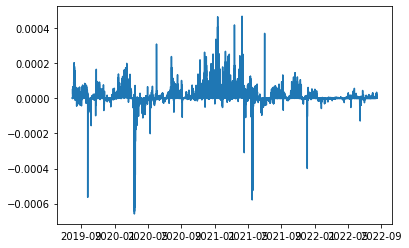

In [106]:
plt.plot(df.datetime, df.interest_1h)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


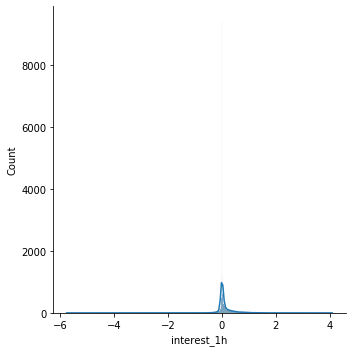

In [107]:
nHoursInYear = 24*365
sns.displot(df.interest_1h*nHoursInYear, kde=True)

In [110]:
np.mean(df.interest_8h)*nHoursInYear/8

0.09751155764343815